In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('沪深300.xlsx', header=3)
df = df.dropna(axis = 1, how = 'all')

bool_cols = []
for column in df.columns:
    if df[column].dtype == 'bool':
        bool_cols.append(column)

df.drop(['tech_MA5', 'tech_MA20'], axis=1, inplace=True)

for column in df.columns:
    if df[column].isnull().any() and column not in bool_cols:
        df[column].fillna(df[column].mean(), inplace=True)
df['trend'] = (df['close'] < df['close'].shift(-1))
df = df.iloc[1:,]
df

,Date,open,high,low,close,volume,amt,dealnum,adjfactor,turn,...,stage_high,stage_low,up_days,down_days,breakout_ma,breakdown_ma,history_high_days,history_low_days,bull_bear_ma,trend
1,2012-05-29,2.602,2.661,2.602,2.644,714949008.0,1.875593e+09,11432,1.000000,6.936538,...,True,True,1.0,0.0,False,False,2,1,False,False
2,2012-05-30,2.642,2.647,2.633,2.636,265887198.0,7.017258e+08,5532,1.000000,2.595794,...,True,True,0.0,1.0,False,False,2,1,False,False
3,2012-05-31,2.621,2.645,2.613,2.630,178155984.0,4.681931e+08,4662,1.000000,1.747313,...,True,False,0.0,2.0,False,False,1,0,False,False
4,2012-06-01,2.629,2.660,2.620,2.630,179350035.0,4.734772e+08,5189,1.000000,1.766249,...,False,False,0.0,0.0,False,False,0,0,False,False
5,2012-06-04,2.601,2.604,2.555,2.558,546074272.0,1.413414e+09,7566,1.000000,5.559705,...,False,False,0.0,1.0,False,False,0,0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3118,2025-03-27,4.011,4.050,3.995,4.027,801525164.0,3.224973e+09,70576,1.207793,0.941116,...,False,False,1.0,0.0,False,False,0,0,False,False
3119,2025-03-28,4.027,4.029,4.000,4.008,704304791.0,2.826193e+09,59846,1.207793,0.828821,...,False,False,0.0,1.0,False,False,0,0,False,False
3120,2025-03-31,4.004,4.024,3.969,3.984,902172863.0,3.600807e+09,110122,1.207793,1.060626,...,False,False,0.0,2.0,False,False,0,0,False,False
3121,2025-04-01,3.988,4.003,3.979,3.982,615015541.0,2.452333e+09,58348,1.207793,0.721766,...,False,False,0.0,3.0,False,False,0,0,False,False


In [3]:
torch.manual_seed(42)
np.random.seed(42)

# Parameters
WINDOW_SIZE = 20
BATCH_SIZE = 64
TARGET_COLUMN = 'trend'
FEATURES = [col for col in df.columns if col not in ['trend', 'Date']]
#FEATURES = ['close']
#FEATURES = ['open', 'high', 'low', 'close', 'volume', 'MACD', 'RSI', 'up_days', 'down_days', 'history_high_days', 'history_low_days']
BOOL_FEATURES = [col for col in FEATURES if df[col].dtype == 'bool']
NUM_FEATURES = [col for col in FEATURES if col not in BOOL_FEATURES]
TEST_SIZE = 0.2
EPOCHS = 100
PATIENCE = 5
DEVICE = "cuda"

In [4]:
class GANDataset(Dataset):
    def __init__(self, df, target_col, feature_cols, window_size):
        self.df = df
        self.target_col = target_col
        self.feature_cols = feature_cols
        self.window_size = window_size

        # Convert boolean features to int
        self.df[BOOL_FEATURES] = self.df[BOOL_FEATURES].astype(int)

    def __len__(self):
        return len(self.df) - self.window_size

    def __getitem__(self, idx):
        # Extract target and feature sequences
        target_seq = self.df[self.target_col].iloc[idx:idx + self.window_size].values
        feature_seq = self.df[self.feature_cols].iloc[idx:idx + self.window_size].values
        
        # Extract target value for the next time step
        target = self.df[self.target_col].iloc[idx + self.window_size]
        
        return (
            torch.FloatTensor(target_seq).unsqueeze(-1),  # [seq_len, 1]
            torch.FloatTensor(feature_seq),              # [seq_len, num_features]
            torch.FloatTensor([target])                  # [1]
        )


In [5]:
class Generator(nn.Module):
    def __init__(self, target_input_dim, feature_input_dim, latent_dim, hidden_dim, num_layers):
        super(Generator, self).__init__()
        self.lstm = nn.LSTM(target_input_dim + feature_input_dim + latent_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, target_seq, feature_seq, noise):
        x = torch.cat([target_seq, feature_seq, noise], dim=2)  # 拼接输入
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])  # 返回最后一个时间步的输出

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, target_input_dim, feature_input_dim, hidden_dim, num_layers):
        super(Discriminator, self).__init__()
        self.lstm = nn.LSTM(target_input_dim + feature_input_dim + 1, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, target_seq, feature_seq, target):
        target = target.unsqueeze(1).repeat(1, target_seq.size(1), 1)  # 扩展并重复目标值
        x = torch.cat([target_seq, feature_seq, target], dim=2)
        out, _ = self.lstm(x)
        return torch.sigmoid(self.fc(out[:, -1, :]))  # 返回概率

In [6]:
# Training GAN
def train_gan(generator, discriminator, train_loader, val_loader, g_optimizer, d_optimizer, criterion, latent_dim, n_epochs, patience):
    best_generator = None
    best_val_loss = float("inf")
    patience_counter = 0

    train_losses = {"generator": [], "discriminator": []}
    val_losses = {"generator": [], "discriminator": []}

    for epoch in range(n_epochs):
        generator.train()
        discriminator.train()

        train_g_loss, train_d_loss = 0, 0
        for target_seq, feature_seq, real_target in train_loader:
            target_seq, feature_seq, real_target = target_seq.to(DEVICE), feature_seq.to(DEVICE), real_target.to(DEVICE)

            batch_size = target_seq.size(0)
            noise = torch.randn(batch_size, target_seq.size(1), latent_dim).to(DEVICE)

            # Train Discriminator
            d_optimizer.zero_grad()
            fake_target = generator(target_seq, feature_seq, noise)
            real_output = discriminator(target_seq, feature_seq, real_target)
            fake_output = discriminator(target_seq, feature_seq, fake_target.detach())
            d_loss_real = criterion(real_output, torch.ones_like(real_output))
            d_loss_fake = criterion(fake_output, torch.zeros_like(fake_output))
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            d_optimizer.step()
            train_d_loss += d_loss.item()

            # Train Generator
            g_optimizer.zero_grad()
            fake_output = discriminator(target_seq, feature_seq, fake_target)
            g_loss = criterion(fake_output, torch.ones_like(fake_output))
            g_loss.backward()
            g_optimizer.step()
            train_g_loss += g_loss.item()

        train_g_loss /= len(train_loader)
        train_d_loss /= len(train_loader)
        train_losses["generator"].append(train_g_loss)
        train_losses["discriminator"].append(train_d_loss)

        # Validation
        generator.eval()
        discriminator.eval()
        val_g_loss, val_d_loss = 0, 0

        with torch.no_grad():
            for target_seq, feature_seq, real_target in val_loader:
                target_seq, feature_seq, real_target = target_seq.to(DEVICE), feature_seq.to(DEVICE), real_target.to(DEVICE)

                batch_size = target_seq.size(0)
                noise = torch.randn(batch_size, target_seq.size(1), latent_dim).to(DEVICE)

                fake_target = generator(target_seq, feature_seq, noise)
                real_output = discriminator(target_seq, feature_seq, real_target)
                fake_output = discriminator(target_seq, feature_seq, fake_target)
                d_loss_real = criterion(real_output, torch.ones_like(real_output))
                d_loss_fake = criterion(fake_output, torch.zeros_like(fake_output))
                val_d_loss += (d_loss_real + d_loss_fake).item()

                g_loss = criterion(fake_output, torch.ones_like(fake_output))
                val_g_loss += g_loss.item()

        val_g_loss /= len(val_loader)
        val_d_loss /= len(val_loader)
        val_losses["generator"].append(val_g_loss)
        val_losses["discriminator"].append(val_d_loss)

        print(f"Epoch {epoch + 1}/{n_epochs}, Train G Loss: {train_g_loss:.4f}, Train D Loss: {train_d_loss:.4f}, "
              f"Val G Loss: {val_g_loss:.4f}, Val D Loss: {val_d_loss:.4f}")

        if val_g_loss < best_val_loss:
            best_val_loss = val_g_loss
            best_generator = generator.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    generator.load_state_dict(best_generator)
    return generator, train_losses, val_losses, best_val_loss

In [7]:
# Evaluation
def evaluate_gan(generator, test_loader, latent_dim):
    generator.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for target_seq, feature_seq, real_target in test_loader:
            target_seq, feature_seq, real_target = target_seq.to(DEVICE), feature_seq.to(DEVICE), real_target.to(DEVICE)

            batch_size = target_seq.size(0)
            noise = torch.randn(batch_size, target_seq.size(1), latent_dim).to(DEVICE)
            fake_target = generator(target_seq, feature_seq, noise)

            y_true.extend(real_target.cpu().numpy())
            y_pred.extend((fake_target > 0.5).float().cpu().numpy())

    return np.array(y_true), np.array(y_pred)

# Metrics calculation
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}


In [8]:
# Visualization
def plot_loss(train_losses, val_losses, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses["generator"], label="Train Generator Loss")
    plt.plot(val_losses["generator"], label="Validation Generator Loss")
    plt.plot(train_losses["discriminator"], label="Train Discriminator Loss")
    plt.plot(val_losses["discriminator"], label="Validation Discriminator Loss")
    plt.title(f"{model_name} Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [9]:
# Main function for GAN
def main_gan():
    # Split data into train and test sets
    train_size = int(len(df) * (1 - TEST_SIZE))
    train_data = df.iloc[:train_size]
    test_data = df.iloc[train_size:]

    # TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=2)

    # The best model and its validation loss
    best_model_state = None
    best_val_loss = float('inf')
    final_train_losses = None
    final_val_losses = None
    best_fold_scaler = None

    for fold, (train_idx, val_idx) in enumerate(tscv.split(train_data)):
        print(f"Fold {fold + 1}")
        fold_train_data = train_data.iloc[train_idx]
        fold_val_data = train_data.iloc[val_idx]

        # Scale data
        scaler = StandardScaler()
        scaler.fit(fold_train_data[NUM_FEATURES])
        fold_train_data[NUM_FEATURES] = scaler.transform(fold_train_data[NUM_FEATURES])
        fold_val_data[NUM_FEATURES] = scaler.transform(fold_val_data[NUM_FEATURES])

        # Create datasets and loaders
        train_dataset = GANDataset(fold_train_data, TARGET_COLUMN, FEATURES, WINDOW_SIZE)
        val_dataset = GANDataset(fold_val_data, TARGET_COLUMN, FEATURES, WINDOW_SIZE)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

        # Model
        g_hidden_dim = 32
        d_hidden_dim = 16
        g_num_layers = 7
        d_num_layers = 5
        latent_dim = 512
        g_lr = 0.01
        d_lr = 0.0001

        generator = Generator(1, len(FEATURES), latent_dim, g_hidden_dim, g_num_layers).to(DEVICE)
        discriminator = Discriminator(1, len(FEATURES), d_hidden_dim, d_num_layers).to(DEVICE)

        g_optimizer = torch.optim.Adam(generator.parameters(), lr=g_lr)
        d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=d_lr)
        criterion = nn.BCELoss()

        # Train GAN
        generator, train_losses, val_losses, fold_best_val_loss = train_gan(
            generator, discriminator, train_loader, val_loader,
            g_optimizer, d_optimizer, criterion, latent_dim, EPOCHS, PATIENCE
        )
        print(f"Fold {fold + 1} The best validation loss is: {fold_best_val_loss:.4f}")

        # Save the best model
        if fold_best_val_loss < best_val_loss:
            best_val_loss = fold_best_val_loss
            best_model_state = generator.state_dict().copy()
            final_train_losses = train_losses
            final_val_losses = val_losses
            best_fold_scaler = scaler
            print(f"The best model is saved in Fold {fold + 1}")

    # Create final generator model and load the best weights
    final_generator = Generator(1, len(FEATURES), latent_dim, g_hidden_dim, g_num_layers).to(DEVICE)
    final_generator.load_state_dict(best_model_state)

    # Plot the loss curves
    plot_loss(final_train_losses, final_val_losses, "GAN")

    # Evaluation on the test set
    print("\nEvaluating the model on the test set...")
    test_data[NUM_FEATURES] = best_fold_scaler.transform(test_data[NUM_FEATURES])
    test_dataset = GANDataset(test_data, TARGET_COLUMN, FEATURES, WINDOW_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    y_true, y_pred = evaluate_gan(final_generator, test_loader, latent_dim)

    # Calculate metrics
    gan_metrics = calculate_metrics(y_true, y_pred)

    print("\nGAN's performance:")
    for metric, value in gan_metrics.items():
        print(f"{metric}: {value:.6f}")

    return {
        'generator': final_generator,
        'gan_metrics': gan_metrics,
        'gan_preds': y_pred,
        'gan_actuals': y_true,
        'scaler': best_fold_scaler
    }

Fold 1
Epoch 1/100, Train G Loss: 0.7909, Train D Loss: 1.3952, Val G Loss: 0.7878, Val D Loss: 1.3944
Epoch 2/100, Train G Loss: 0.7828, Train D Loss: 1.3938, Val G Loss: 0.7795, Val D Loss: 1.3932
Epoch 3/100, Train G Loss: 0.7747, Train D Loss: 1.3925, Val G Loss: 0.7714, Val D Loss: 1.3920
Epoch 4/100, Train G Loss: 0.7665, Train D Loss: 1.3914, Val G Loss: 0.7633, Val D Loss: 1.3909
Epoch 5/100, Train G Loss: 0.7583, Train D Loss: 1.3904, Val G Loss: 0.7553, Val D Loss: 1.3899
Epoch 6/100, Train G Loss: 0.7501, Train D Loss: 1.3894, Val G Loss: 0.7472, Val D Loss: 1.3890
Epoch 7/100, Train G Loss: 0.7418, Train D Loss: 1.3886, Val G Loss: 0.7390, Val D Loss: 1.3883
Epoch 8/100, Train G Loss: 0.7335, Train D Loss: 1.3879, Val G Loss: 0.7309, Val D Loss: 1.3877
Epoch 9/100, Train G Loss: 0.7252, Train D Loss: 1.3873, Val G Loss: 0.7232, Val D Loss: 1.3872
Epoch 10/100, Train G Loss: 0.7172, Train D Loss: 1.3869, Val G Loss: 0.7158, Val D Loss: 1.3868
Epoch 11/100, Train G Loss: 0.71

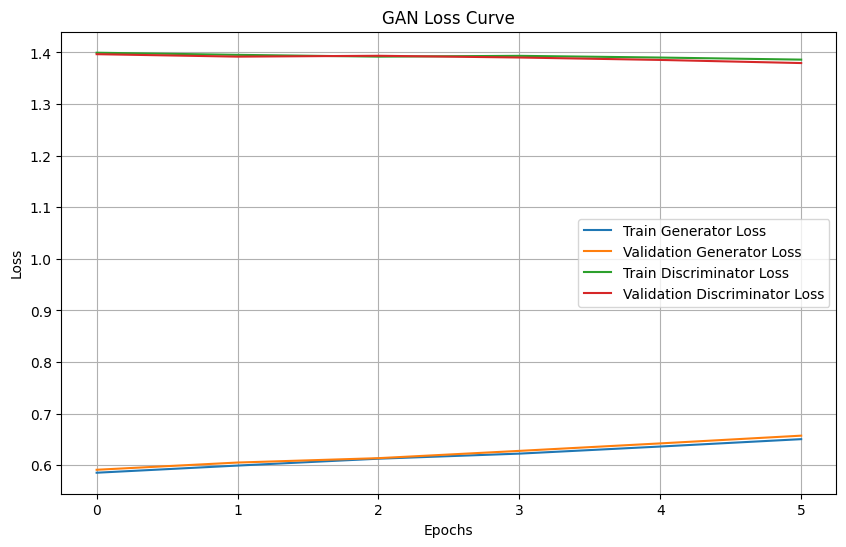


Evaluating the model on the test set...

GAN's performance:
Accuracy: 0.444628
Precision: 0.444628
Recall: 1.000000
F1 Score: 0.615561



In [12]:
gan_results = main_gan()
print()